# Modelling and prediction of a CVD process

## Problem
- Model layer thickness resulting from a CVD process, based on set of DOE data
- Thickness was measured at 49 sites across a wafer

## Goals
1. Use regression model to predict thickness for every single site
2. Adapt model to also consider X and Y coordinates of the site to form a single model
3. Implement model to include temperature as process parameter

## Possible improvements
- Hyperparameter tuning for ANN, improve stability of model quality, show learning rate
- Encode TOOL into dummy variables instead of scalar
- Encode X, Y coordinates into dummy variables / allow for prediction based on any X and Y coordinates, not only fixed sites

## 1. Preprocessing
### Import data
- Import raw data from csv files
- Set all independant variables as X as array
- Set dependant variable Layer thickness as y

### Split data & Feature scaling
- Split into training and test data (75:25)
- Fix seed for randomness
- Scale all features using StandardScaler

### Inlcude temperature in model
- Thickness factors from literature:
  - 500 °C = 0.94
  - 480 °C = 1.0 (*default*)
  - 460 °C = 1.04
- Calculated scaling formula for CVD thickness d depending on temperature:
  - d = d_0 * (-0.0025 * temperature + 2.1933)
  - temperature_factor(480) = 1 (except rounding error)
- Temperature is not needed as feature in training data since linear model is assumed  

In [275]:
import pandas as pd
import numpy as np
from tkinter import *
from tkinter.ttk import Combobox
from matplotlib.figure import Figure
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from numpy.random import seed
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import RMSprop
from tensorflow import random

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

seed(0)
random.set_seed(0)

DIR = './'
SITES = 'site_coordinates.csv'
DATA = 'test_assignment_sim.csv'

raw_sites = pd.read_csv(DIR+SITES)
raw_data = pd.read_csv(DIR+DATA)

X = raw_data.iloc[:,0:4]
y = raw_data.iloc[:,4:53]

def preprocess(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)
    sc_X = StandardScaler()
    X_train = sc_X.fit_transform(X_train)
    X_test = sc_X.transform(X_test)
    sc_y = StandardScaler()
    y_train = sc_y.fit_transform(y_train)
    return X_train, X_test, y_train, y_test, sc_X, sc_y

def temperature_factor(temperature):
    '''Returns CVD layer thickness scaling factor for a given temperature.'''
    return -0.0025 * float(temperature) + 2.1933

## 2. Train model

In [239]:
# 4 input nodes
# 2 layers of 27 nodes
# 49 output nodes

X_train, X_test, y_train, y_test, sc_X, sc_y = preprocess(X, y)
regressor = Sequential()
regressor.add(Dense(units=27, activation='relu', input_dim=X_train.shape[1]))
regressor.add(Dense(units=27, activation='relu'))
regressor.add(Dense(units=49))
regressor.compile(optimizer=RMSprop(0.001), loss='mse', metrics=['mae','mse'])
regressor.fit(X_train, y_train, batch_size=10, epochs=200, verbose=0, use_multiprocessing=True)
y_pred = sc_y.inverse_transform(regressor.predict(X_test))
r2_ann_multi = r2_score(y_test, y_pred)
print('r^2 score: ', r2_ann_multi);

r^2 score:  0.981680264282583


## 3. Predictions
- Defines prediction function
- Creates GUI window to allow easy editing of process parameters or use prediction in notebook
- Shows predicted layer thickness for all sites in window
- Shows wafer map of thickness distribution in Jupyter notebook after GUI is closed

In [302]:
def predict(notebook=False):
    if notebook:
        flow = 0.92
        spacing = 0.35
        deptime = 70
        temperature = 480
        tool = 1
    else:
        flow = in_flow.get()
        spacing = in_spacing.get()
        deptime = in_deptime.get()
        temperature = in_temperature.get()
        tool = cb_tool.get()
    
    parameters = np.array([flow, spacing, deptime, tool]).reshape(1,-1)
    parameters = sc_X.transform(parameters)
    print('Process parameters:\nFLOWFACTOR:\t{}\nSPACING:\t{}\nDEP TIME:\t{} s\nTOOL:\t\t#{}\nTemperature:\t{} °C\n'.format(
    flow, spacing, deptime, tool, temperature))
    y_pred = sc_y.inverse_transform(regressor.predict(parameters)) * temperature_factor(temperature)
    
    if notebook:
        print('Predicted SiO2 layer thickness for all sites (1 - 49):\n\n', y_pred)
    else: 
        lbl_result = Label(window, text="Thickness prediction: ", font=("Helvetica", 11))
        lbl_result.place(x=pos_x_labels, y=y_tool+70)
        result_box = Listbox(window, height=20)
        for _ in range(0, len(y_pred[0])):
            entry = 'Site ' + str(_) + ': ' + str(y_pred[0][_])
            result_box.insert(_+1, entry)
        result_box.place(x=pos_x_labels+3, y=y_tool+95)
    
    df_pred = pd.DataFrame()
    df_pred['Prediction'] = y_pred.flatten()
    df_pred['X'] = raw_sites.SITE_X.values.round(0)
    df_pred['Y'] = raw_sites.SITE_Y.values.round(0)
    fig, ax1 = plt.subplots()
    fig = Figure(figsize = (9, 6), facecolor = "white")
    ax1.set_title('Predicted SiO2 layer thickness')

    df_pred.plot.scatter('X', 'Y', c='Prediction', colormap='Blues', ax=ax1)
    return y_pred

Process parameters:
FLOWFACTOR:	0.92
SPACING:	0.35
DEP TIME:	70 s
TOOL:		#1
Temperature:	480 °C

Predicted SiO2 layer thickness for all sites (1 - 49):

 [[1566.6394 1516.5896 1569.493  1568.1709 1566.4678 1565.4136 1570.3058
  1570.922  1570.2164 1622.5685 1622.0509 1621.2283 1620.6143 1620.0347
  1619.7888 1618.7257 1619.5199 1618.6635 1622.9792 1623.565  1623.6831
  1623.9048 1624.4808 1623.137  1623.0607 1599.2683 1598.7465 1598.635
  1598.5309 1597.9188 1596.967  1596.46   1596.0399 1594.5374 1594.0562
  1593.6328 1592.9905 1593.3906 1596.6774 1596.9202 1598.4688 1598.4441
  1598.2537 1598.4424 1599.0908 1599.4822 1599.5094 1599.303  1599.316 ]]


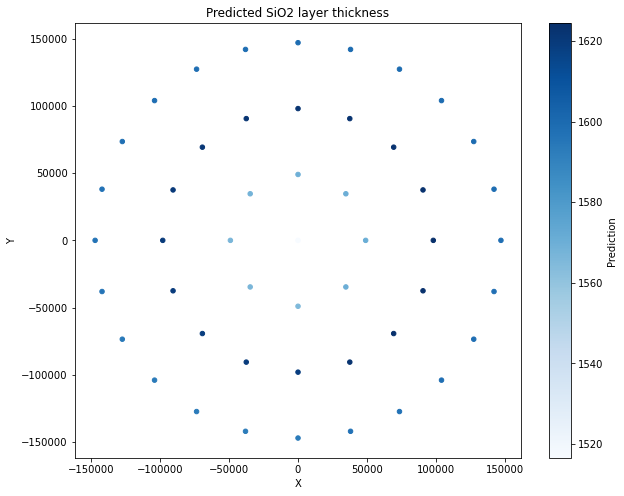

In [298]:
predict(notebook=True);

In [305]:
window = Tk()
width = 450
height = 600
pos_x = '+0' # Specify +/- for position from left or right side
pos_y = '+0' # Specify +/- for position from left or right side
window.title('CVD process predicter')
window.geometry('{}x{}{}{}'.format(width, height, pos_x, pos_y))
#window.config()

lbl_intro = Label(window, text="Define process parameters", font=("Helvetica", 10))
lbl_intro.place(x=5, y=5)

pos_x_labels = 5
pos_y_labels = 35
pos_x_in = pos_x_labels + 150

lbl_flow = Label(window, text="Flow factor: ", font=("Helvetica", 11))
lbl_flow.place(x=pos_x_labels, y=pos_y_labels)
in_flow = Entry(window, bd=1)
in_flow.insert(0, '0.93')
in_flow.place(x=pos_x_in, y=pos_y_labels+2)

lbl_spacing = Label(window, text="Spacing: ", font=("Helvetica", 11))
lbl_spacing.place(x=pos_x_labels, y=pos_y_labels+5*6)
in_spacing = Entry(window, bd=1)
in_spacing.insert(0, '0.35')
in_spacing.place(x=pos_x_in, y=pos_y_labels+5*6+2)

lbl_deptime = Label(window, text="Deposition time [s]: ", font=("Helvetica", 11))
lbl_deptime.place(x=pos_x_labels, y=pos_y_labels+5*11)
in_deptime = Entry(window, bd=1)
in_deptime.insert(0, '68')
in_deptime.place(x=pos_x_in, y=pos_y_labels+5*11+2)

lbl_temperature = Label(window, text="Temperature [°C]: ", font=("Helvetica", 11))
lbl_temperature.place(x=pos_x_labels, y=pos_y_labels+5*16)
in_temperature = Entry(window, bd=1)
in_temperature.insert(0, '480')
in_temperature.place(x=pos_x_in, y=pos_y_labels+5*16+2)

y_tool = pos_y_labels+5*21
lbl_tool = Label(window, text="Tool: ", font=("Helvetica", 11))
lbl_tool.place(x=pos_x_labels, y=y_tool)
cb_tool = Combobox(window, values=['1', '2', '3', '4'])
cb_tool.place(x=pos_x_in, y=y_tool)
cb_tool.current(0)


btn = Button(window, text="Calculate", fg='blue', command=predict)
btn.place(x=pos_x_labels, y=y_tool+35);

Process parameters:
FLOWFACTOR:	0.93
SPACING:	0.35
DEP TIME:	68 s
TOOL:		#1
Temperature:	480 °C



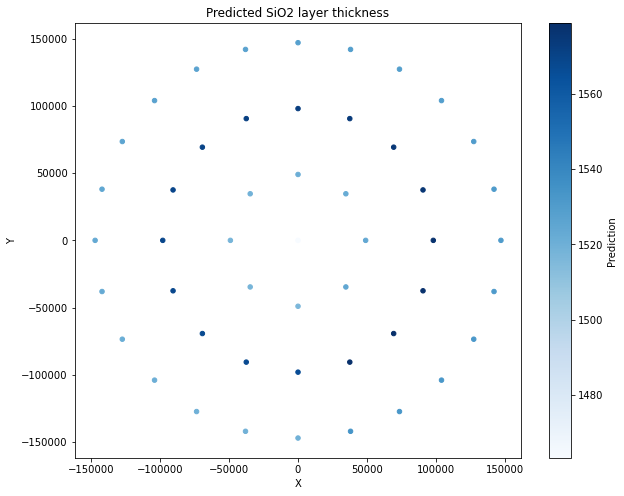

In [306]:
window.mainloop();